In [1]:
from qiskit import *
from qiskit_aer import AerSimulator

# Section A

In [2]:
# Create quantum circuit with 3 qubits and 3 classical bits
qubits = QuantumRegister(3, 'q')
clbits = ClassicalRegister(3, 'c')
circuit = QuantumCircuit(qubits, clbits)
(q0, q1, q2) = qubits
(c0, c1, c2) = clbits
 

# Initialize first qubit to |1⟩ state
circuit.x(1) 

circuit.barrier() 

# Create Bell pair between qubits 1 and 2
circuit.h(1)
circuit.cx(1,2)

circuit.barrier() 

# Perform Bell measurement on qubits 0 and 1
circuit.cx(0,1)
circuit.h(0)

circuit.barrier() 

# Measure qubits 0 and 1
circuit.measure([0, 1], [0, 1]) 

circuit.barrier() 

# Apply correction operations on qubit 2 based on measurement results
circuit.cx(1, 2)  # Apply X gate if measurement of qubit 1 is |1⟩
circuit.cz(0, 2)  # Apply Z gate if measurement of qubit 0 is |1⟩

# Measure the final state of qubit 2 (the teleported state)
circuit.measure([2], [2])

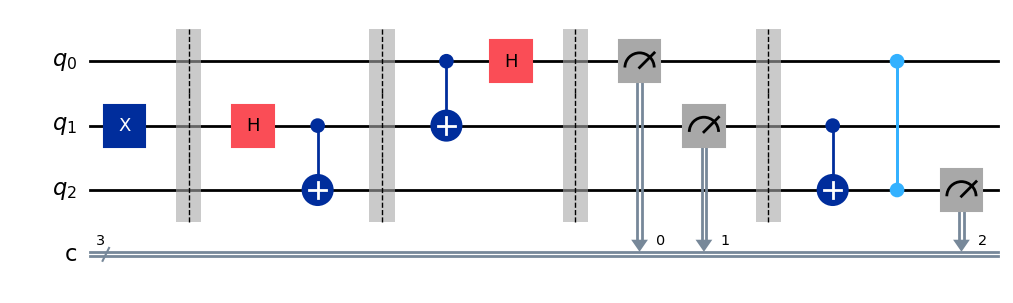

In [3]:
%matplotlib inline
circuit.draw(output='mpl')

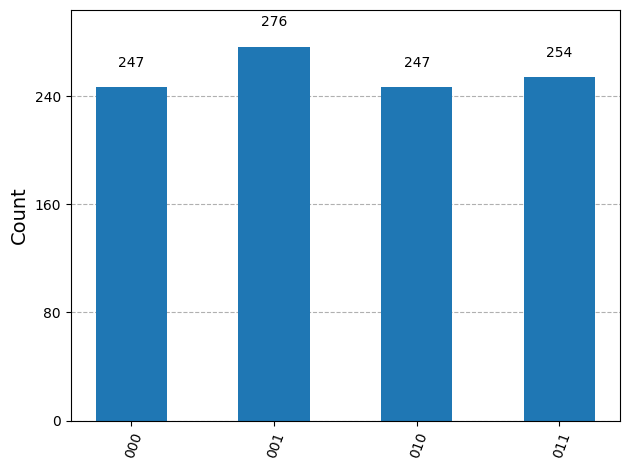

In [4]:
simulator = AerSimulator()
job = simulator.run(circuit, shots=1024)
result = job.result()
from qiskit.visualization import plot_histogram
plot_histogram(result.get_counts(circuit))


## Results Analysis

The histogram shows the measurement outcomes from running the quantum teleportation circuit 1024 times.

We observe four possible measurement outcomes: '000', '001', '010', and '011'.

The most frequent outcome is '011' with 277 counts (approximately 27% of shots).
This is followed by '000' with 267 counts (26%), '001' with 249 counts (24%), and '010' with 231 counts (23%).

The relatively even distribution between these states suggests the quantum teleportation protocol is working as expected, with the correction operations successfully teleporting the initial state. The small variations in counts can be attributed to quantum noise and statistical fluctuations in the measurements.


# Section B

## Quantum State Tomography

Quantum State Tomography (QST) is a process used to experimentally determine 
the quantum state of a system. It works by performing multiple measurements
in different bases to reconstruct the complete density matrix of the quantum state.


The process involves:
1. Preparing many identical copies of the quantum state
2. Measuring each copy in different measurement bases
3. Using the measurement statistics to reconstruct the density matrix



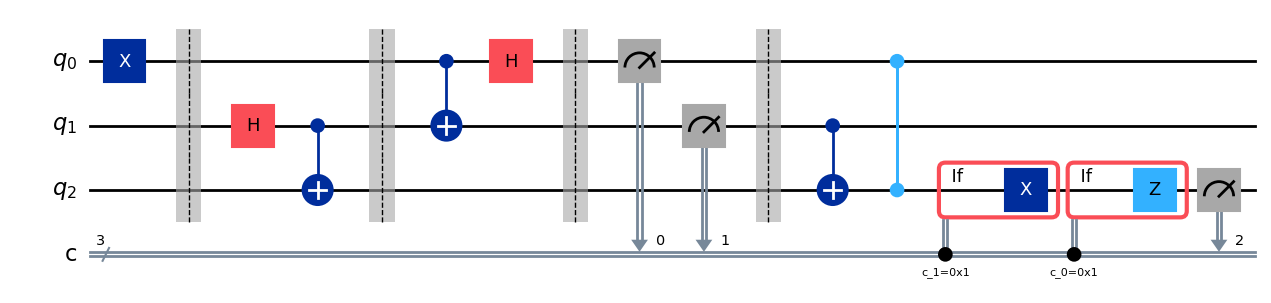

In [5]:
# Create quantum circuit with 3 qubits and 3 classical bits
qubits = QuantumRegister(3, 'q')
clbits = ClassicalRegister(3, 'c')
circuit = QuantumCircuit(qubits, clbits)
(q0, q1, q2) = qubits
(c0, c1, c2) = clbits
 
# Initialize first qubit to |1⟩ state
circuit.x(0) 

circuit.barrier() 

# Create Bell pair between qubits 1 and 2
circuit.h(1)
circuit.cx(1,2)

circuit.barrier() 

# Perform Bell measurement on qubits 0 and 1
circuit.cx(0,1)
circuit.h(0)

circuit.barrier() 

# Measure qubits 0 and 1
circuit.measure([0, 1], [0, 1]) 

circuit.barrier() 

# Apply correction operations on qubit 2 based on measurement results
circuit.cx(1, 2)  # Apply X gate if measurement of qubit 1 is |1⟩
circuit.cz(0, 2)  # Apply Z gate if measurement of qubit 0 is |1⟩

# Apply correction operations on qubit 2 based on measurement results using dynamic circuits
with circuit.if_test((c1,0x1)):
    circuit.x(q2)
with circuit.if_test((c0,0x1)):
    circuit.z(q2)

circuit.measure([2], [2]) 

circuit.draw("mpl")





In [6]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakePerth

backend = AerSimulator.from_backend(FakePerth())

In [7]:
import qiskit
from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import StateTomography

# QST Experiment
qstexp1 = StateTomography(circuit)
qstdata1 = qstexp1.run(backend, seed_simulation=100).block_for_results()

# Print results
display(qstdata1.analysis_results(dataframe=True))

,name,experiment,components,value,quality,backend,run_time,trace,eigvals,raw_eigvals,rescaled_psd,fitter_metadata,conditional_probability,positive
05bd5d28,state,StateTomography,"[Q0, Q1, Q2]","DensityMatrix([[ 0.03075987+0.00000000e+00j, ...",None,aer_simulator_from(fake_perth),None,1.0,"[0.24955547706392395, 0.22975624941678302, 0.2...","[0.2502902424499584, 0.23049101480281747, 0.22...",True,"{'fitter': 'linear_inversion', 'fitter_time': ...",1.0,True
1e1f6246,positive,StateTomography,"[Q0, Q1, Q2]",True,None,aer_simulator_from(fake_perth),None,None,None,None,None,None,None,None


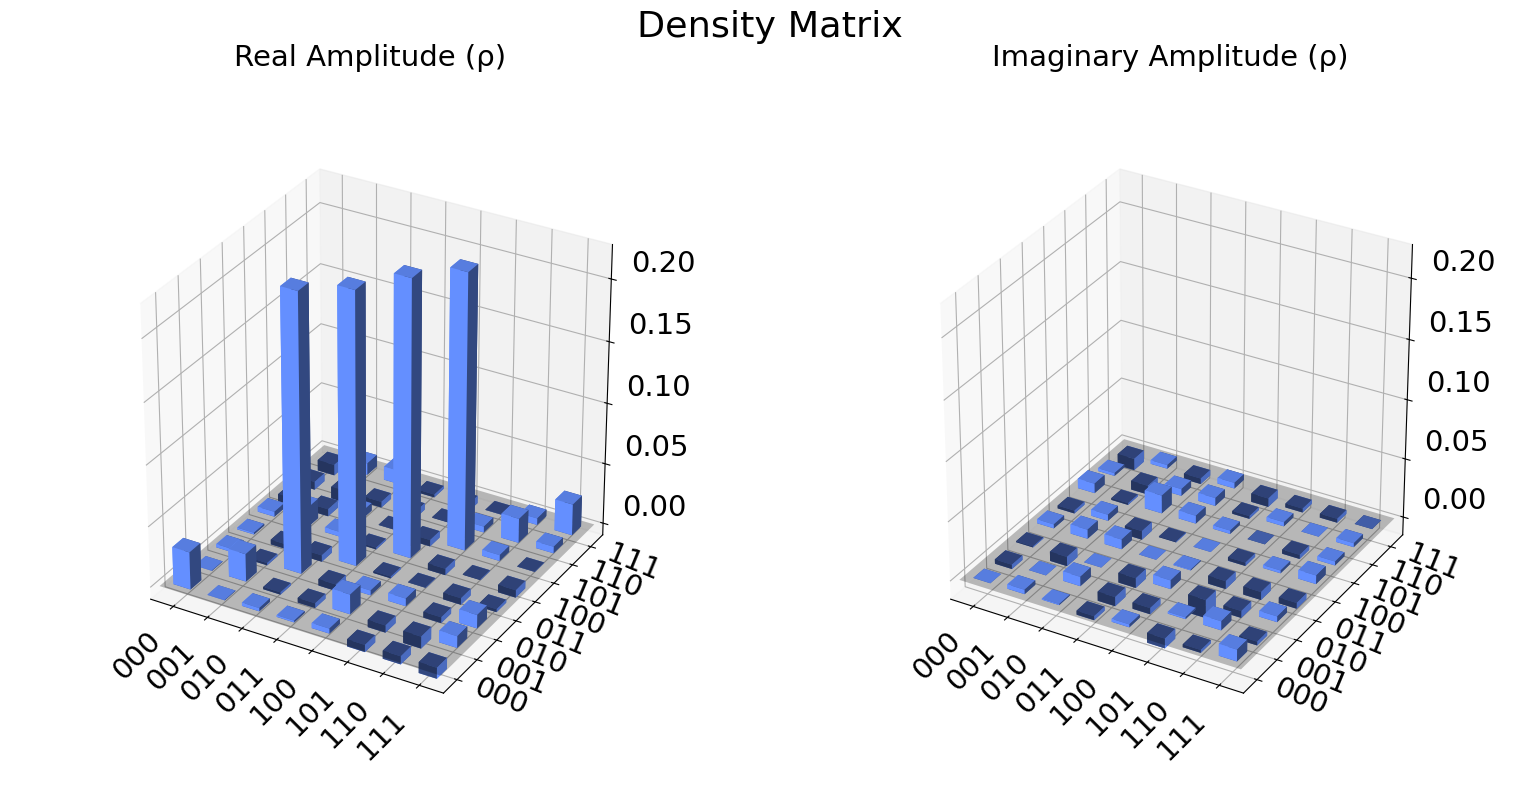

In [8]:
from qiskit.visualization import plot_state_city
state = qstdata1.analysis_results("state", dataframe=True).iloc[0].value
plot_state_city(state, title='Density Matrix')